# Setup

We'll broadly use standard python machinery for everything here.

In [258]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

# The Thinning Algorithm (Ogata, 1981)

We can simulate generalized point processes with Ogata's thinning algorithm. It is not necessarily an exact simulation, but it's the most compact and fastest approximate algorithm we have. The reasons for it working may seem unreasonably simplistic, but in general I find it to be a good starting point for any benchmarking analysis we want. 

The algorithm itself is
```
1 - Set a horizon T, initialize time counter t=0, initialize event history set H = {}
2 - Define an intensity function (which may be autocorrelated) λ(t,H)
3 - While t<T:
    (a) estimate an upper bound intensity given current history λ* = sup_t(λ(t,H))
    (b) sample random timestep: draw u~U(0,1) set τ = -ln(u)/λ*
    (c) update time counter: t = max(T, t + τ)
    (d) sample whether a new event happened: draw s~U(0,1)
        if s<=λ(t,H)/λ*, an event happens: H <- t  
        otherwise, perform no updates 
    return to (a)
```

Here's a sample implementation in numpy:

In [292]:
def Thinning_Sim(T, Base_Rate,Kernel=Blank_Kernel()):
    sample = np.array([]) # create empty array 
    t = np.zeros(1) # starting time
    while t[0]<T: # loop until you pass the observation horizon
        h0 = max(Base_Rate)+Kernel.bound(t,T,sample) # get upper bound
        u  = np.random.uniform(0,1,size=1) 
        t1  = -np.log(u)/h0 # generate random timestep
        t = min(T,t+t1) # make sure the timestep doesn't go too far (out of the observation horizon) 
        h1 = Base_Rate[int(t)-1]+Kernel.pulse(t,sample) # get intensity at new timestep
        s = np.random.uniform(0,1,size=1)[0]
        if s<=h1/h0: # randomly accept whether an event happened at this timestep
            sample = np.append(sample, t)
    return sample

For starters, let's simulate a purely exogenous (so non-Hawkes) point process:

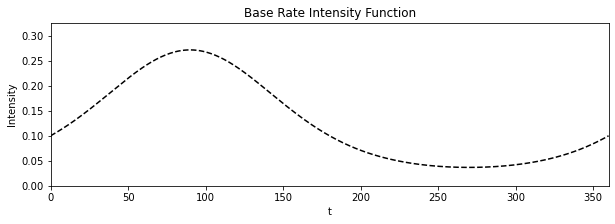

(sub)Sample data as a list of event times:
[ 1.04620946 16.96096472 20.57724515 22.54751455 25.82994889 27.36118704
 36.60664348 37.06938058 47.84152917 67.18297019]



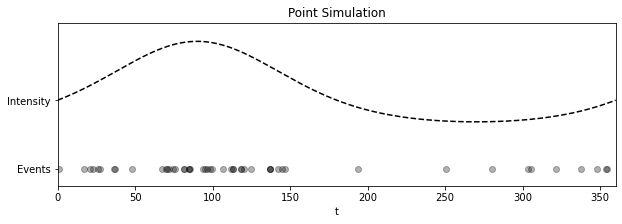

In [293]:
# create a toy blank kernel that turns off the feedback loop
class Blank_Kernel:
    def __init__(self):
        return
    def bound(self,t,T,H):
        return np.zeros(1)
    def pulse(self,t,H):
        return np.zeros(1)
    
# set time horizon
horizon = np.array([360])

# build base rate function (really WHATEVER you want, it virtually has no restrictions)
timesteps = np.linspace(0, horizon[0], horizon[0])
base_rate = np.exp(np.sin(timesteps * (2 * math.pi)))/10

# get a good graph for that
fig, ax = plt.subplots(nrows=1,figsize=(10, 3))
ax.set_xlim(xmin=0,xmax=horizon)
ax.set_ylim(ymin=0,ymax=1.2*max(base_rate))
ax.plot(timesteps,base_rate,color="black",linestyle='--')
ax.set_xlabel("t")
ax.set_ylabel("Intensity")
ax.set_title("Base Rate Intensity Function")
plt.show()

# simulate some points
simulated_sample = Thinning_Sim(horizon, base_rate)
print("(sub)Sample data as a list of event times:")
print(simulated_sample[:10])
print()

# plot those points againts the intensity function
fig, ax = plt.subplots(nrows=1,figsize=(10, 3))
ax.set_xlim(xmin=0,xmax=horizon)
ax.set_ylim(ymin=-0.15,ymax=1.2*(max(base_rate)))
ax.scatter(simulated_sample,np.zeros(len(simulated_sample))-0.1, color = "black", alpha=0.3)
ax.plot(timesteps,base_rate,color="black",linestyle='--')
ax.set_xlabel("t")
ax.set_yticks([-0.1,base_rate[0]])
ax.set_yticklabels(["Events","Intensity"])
ax.set_title("Point Simulation")
plt.show()

Of course, we can expand that by adding any autocorrelation kernel we want to the intensity function. Here's the all-star of Hawkes models, the exponential kernel:

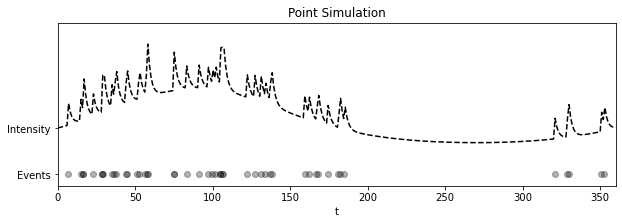

In [297]:
class Exp_Kernel:
    def __init__(self,params):
        self.α = params[0]
        self.β = params[1]
        
    def bound(self,t,T,H):
        grid = np.linspace(t[0],T[0],int(T[0]-t[0]+1)).reshape(-1,1) 
        deltas = grid - H.copy().reshape(1,-1).repeat(grid.shape[0],axis=0)
        raw = self.α*np.exp(-self.β*deltas)
        aggregate = np.sum((deltas>0)*raw,1)
        return max(aggregate)
    
    def pulse(self,t,H):
        t = t.copy().reshape(-1,1)
        deltas = t - H.copy().reshape(1,-1).repeat(t.shape[0],axis=0) 
        raw = self.α*np.exp(-self.β*deltas)
        aggregate = np.sum((deltas>0)*raw,1)
        return aggregate
    
params = [0.1, 0.5]
kernel = Exp_Kernel(params)
    
# simulate some points
simulated_sample = Thinning_Sim(horizon, base_rate, kernel)

# estimate intensity at each step:
total_intensity = base_rate + kernel.pulse(timesteps,simulated_sample)

# plot those points againts the intensity function
fig, ax = plt.subplots(nrows=1,figsize=(10, 3))
ax.set_xlim(xmin=0,xmax=horizon)
ax.set_ylim(ymin=-0.15,ymax=1.2*(max(total_intensity)))
ax.scatter(simulated_sample,np.zeros(len(simulated_sample))-0.1, color = "black", alpha=0.3)
ax.plot(timesteps,total_intensity,color="black",linestyle='--')
ax.set_xlabel("t")
ax.set_yticks([-0.1,base_rate[0]])
ax.set_yticklabels(["Events","Intensity"])
ax.set_title("Point Simulation")
plt.show()

We can use this to simulate data for any other kernel we want. Sticking to the exp kernel we can simulate 500 processes as prototype data. Think of this as simulating spending times for 500 heterogeneous customers.

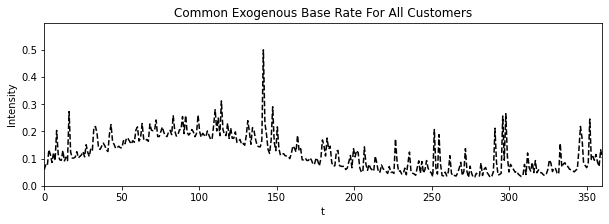

In [414]:
# Find a common base rate to simulate external conditions
base_rate = np.exp(np.sin(timesteps * (2 * math.pi)))/20 + np.exp(np.random.normal(-4,1,len(timesteps)))
for k in range(1,len(base_rate)):
    base_rate[k] += 0.2*base_rate[k-1] 

fig, ax = plt.subplots(nrows=1,figsize=(10, 3))
ax.set_xlim(xmin=0,xmax=horizon)
ax.set_ylim(ymin=0,ymax=1.2*max(base_rate))
ax.plot(timesteps,base_rate,color="black",linestyle='--')
ax.set_xlabel("t")
ax.set_ylabel("Intensity")
ax.set_title("Common Exogenous Base Rate For All Customers")
plt.show()

hyperparams = [0.05,0.5,0.5,0.1]
horizon = np.array([360])
dataset = pd.DataFrame(columns = ["ID","Params","Observations"])

for i in range(500):
    params = [np.exp(np.random.normal(np.log(hyperparams[0]),hyperparams[1])),
              np.exp(np.random.normal(np.log(hyperparams[2]),hyperparams[3]))
             ] 
    kernel = Exp_Kernel(params)
    simulated_sample = Thinning_Sim(horizon, base_rate, kernel)
    new = pd.DataFrame({
        "ID":i,
        "Params":[params],
        "Observations":[simulated_sample]
    })
    dataset = pd.concat([dataset,new])
#dataset.to_csv("Unidi_Sample.csv")

# Bibliography

Ogata, Y. (1981). On Lewis’ simulation method for point processes. IEEE Transactions on Information Theory, 27(1), 23–31. https://doi.org/10.1109/TIT.1981.1056305
